In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pickle
from IPython.display import YouTubeVideo
import warnings
warnings.simplefilter('ignore', UserWarning)
import time
import os
if not os.path.exists('../data/gan-sin'):
    os.mkdir('../data/gan-sin')

import keras
print('Keras', keras.__version__)
from keras import backend as K
print('GPU:', K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


Keras 2.2.4
GPU: []


# Generative Adversarial Networks

In this exercise we we'll train a simple GAN for generating sinus signals.

We follow a [blog post by Robin Ricard](https://www.rricard.me/machine/learning/generative/adversarial/networks/keras/tensorflow/2017/04/05/gans-part2.html).

In a real problem, we'll have to collect the data, but this is a simplified example, so let's start by generating a dataset of sinus signals.
We generat 10,000 signals, with 50 data points per sample. We keep them in an array `vectors` with shape `(10000, 50)`.
The plot shows the first 5 signals.

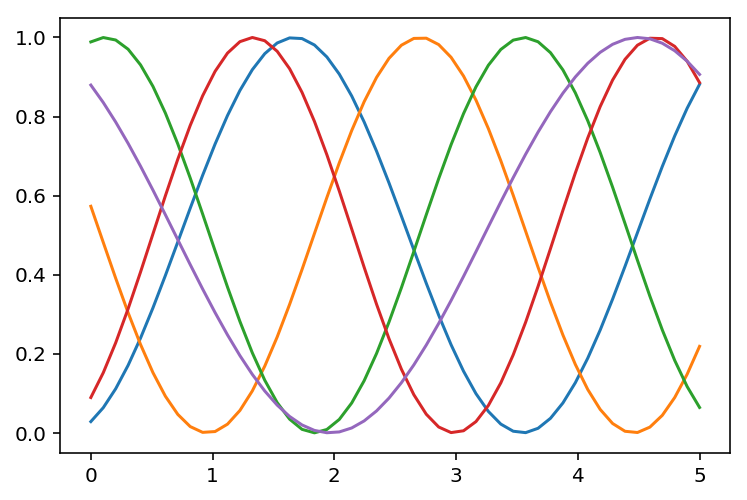

In [3]:
npts = 50
nsamples = 10000

t = np.linspace(0, 5, npts)
vectors = []

offset = np.random.random(size=nsamples) * 100
offset = offset.reshape((-1, 1))
mul = 1 + np.random.random(size=nsamples)
mul = mul.reshape((-1, 1))
vectors = np.sin(offset + t * mul) / 2 + 0.5

ntest = 100
offset = np.random.random(size=ntest) * 100
offset = offset.reshape((-1, 1))
mul = 1 + np.random.random(size=ntest)
mul = mul.reshape((-1, 1))
test_vectors = np.sin(offset + t * mul) / 2 + 0.5

for y in vectors[:5]:
    plt.plot(t, y)

## Discriminator

Let's start with a discriminator network. 

**Create a model called `discriminator`** with input has shape `(50,)` for a signal array and output shape `(1,)` for a single classification of 0 or 1 for _fake_ or _real_, respectively.

Think: How many layers are needed? Can you use a convolution on a 1D signal?

In [4]:
vector_shape = [50]

layers = [
    keras.layers.Reshape(target_shape=(-1, 1), input_shape=vector_shape),
    keras.layers.Conv1D(50, 5, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(50),
    keras.layers.Dense(1, activation='sigmoid') # binomial classifier
]
nn = keras.models.Sequential(layers)

vector = keras.Input(shape=vector_shape)
calssification = nn(vector)

In [5]:
discriminator = keras.models.Model(vector, calssification, name='discriminator')
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

## Generator

Now we create a generator network.

**Create a model called `generator`** with input has shape `(10,)` for a latent vector (i.e. random noise) and output shape `(50,)` for a single signal array.

Think: How many layers will you use? What kind of an activation function should you use?

In [8]:
noise_shape = (10,)

layers = [
    keras.layers.Dense(256, input_shape=noise_shape),
    keras.layers.Activation('tanh'),
    keras.layers.Dense(npts),
    keras.layers.Activation('tanh'),
]
nn = keras.models.Sequential(layers)

noise = keras.Input(shape=noise_shape)
vector = nn(noise)

In [9]:
generator = keras.models.Model(noise, vector, name='generator')
generator.compile(
    loss='binary_crossentropy', 
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

## Connections

The generator takes noise as input and generates vectors.

In [10]:
vector = generator(noise)

The combined model will take noise and produce _fake_/_real_ classification.

For the combined model we will only train the generator:

In [11]:
discriminator.trainable = False

The discriminator takes generated vectors as input and determines validity:

In [12]:
valid = discriminator(vector)

## Combined model

Now we create a combined model.

**Create a model called `combined`** with input has shape `(10,)` for a latent vector (i.e. random noise) and output shape `(1,)` for a classification:
The pipeline is: noise as input => generates vectors => determines validity.

In [13]:
combined = keras.models.Model(noise, valid)
combined.compile(
    loss='binary_crossentropy',
    optimizer=generator.optimizer,
    metrics=['accuracy']
)

## Saving generated vectors

The following function samples signals from the generator and saves them to an image in a `../data/gan-sin` folder.

In [14]:
def save_vecs(idx):
    noise = np.random.normal(0, 1, (4, 10))
    gen_vecs = generator.predict(noise)

    fig, axs = plt.subplots(2, 2)
    cnt = 0
    for i in range(2):
        for j in range(2):
            axs[i,j].plot(gen_vecs[cnt, :])
            cnt += 1
    fig.savefig("../data/gan-sin/sin_{:05d}.png".format(idx))
    plt.close()

## Training

**Choose the number of epochs and the batch size** and then run the training loops.

At each training loop we let the generator generate `half_batch` vectors and stack them with `half_batch` real vectors (i.e. that we generated manually...). 
We train the discriminator using this set using the ground truth: `half_batch` zeros and `half_batch` ones as labels.

We then generate `batch_size` vectors from the generator and train the combined using `batch_size` ones as labels, as we want the generator to generate vectors that the discriminator would classify as _real_.

In [12]:
epochs = 100
batch_size = 32
batches_per_epoch = nsamples//batch_size
half_batch = batch_size // 2
save_interval = 1
print_interval = 1
nvecs = vectors.shape[0]

train_history = defaultdict(list)
test_history = defaultdict(list)

In [13]:
for epoch in range(epochs):
    for batch in range(batches_per_epoch):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of vectors
        idx = np.random.randint(0, nvecs, half_batch)
        real_vecs = vectors[idx]

        noise = np.random.normal(0, 1, (half_batch, 10))

        # Generate a half batch of new images
        gen_vecs = generator.predict(noise)

        # Train the discriminator
        vecs = np.concatenate((real_vecs, gen_vecs))
        valid = np.concatenate((np.ones(half_batch), np.zeros(half_batch)))
        dloss, dacc = discriminator.train_on_batch(
            vecs, 
            valid
        )

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 10))

        # The generator wants the discriminator to label the generated samples as valid (ones)
        valid = np.ones(batch_size)

        # Train the generator
        gloss, gacc = combined.train_on_batch(
            noise, 
            valid
        )

        train_history['dloss'].append( dloss )
        train_history['gloss'].append( gloss )
        train_history['dacc'].append( dacc )
        train_history['gacc'].append( gacc )
    
    # test discriminator
    noise = np.random.normal(0, 1, (ntest, 10))
    gen_vecs = generator.predict(noise)
    x = np.concatenate((test_vectors, gen_vecs))
    y_valid = np.ones(ntest*2)
    y_valid[ntest:] = 0
    
    dloss, dacc = discriminator.evaluate(x, y_valid, verbose=0)
    
    # test generator
    noise = np.random.normal(0, 1, (ntest, 10))
    valid_y = np.ones(ntest)    
    gloss, dloss = combined.evaluate(noise, valid_y, verbose=0)
    
    test_history['dloss'].append( dloss )
    test_history['dacc'].append( dacc )
    test_history['gloss'].append( gloss )
    test_history['gacc'].append( gacc )
    
    # If at save interval => save generated vector samples
    if epoch % save_interval == 0:
        save_vecs(epoch//save_interval)

## History

We save the models and the history, then reload them to plot the history:

In [14]:
generator.save('../data/gan_sin_generator.h5')
discriminator.save('../data/gan_sin_discriminator.h5')
combined.save('../data/gan_sin_combined.h5')

In [15]:
with open('../data/gan_sin_history.p', 'wb') as f:
    pickle.dump([train_history, test_history], f)

In [16]:
with open('../data/gan_sin_history.p', 'rb') as f:
    train_history, test_history = pickle.load(f)

In [17]:
dloss = np.array(test_history['dloss'])
gloss = np.array(test_history['gloss'])
dacc = np.array(test_history['dacc'])
gacc = np.array(test_history['gacc'])

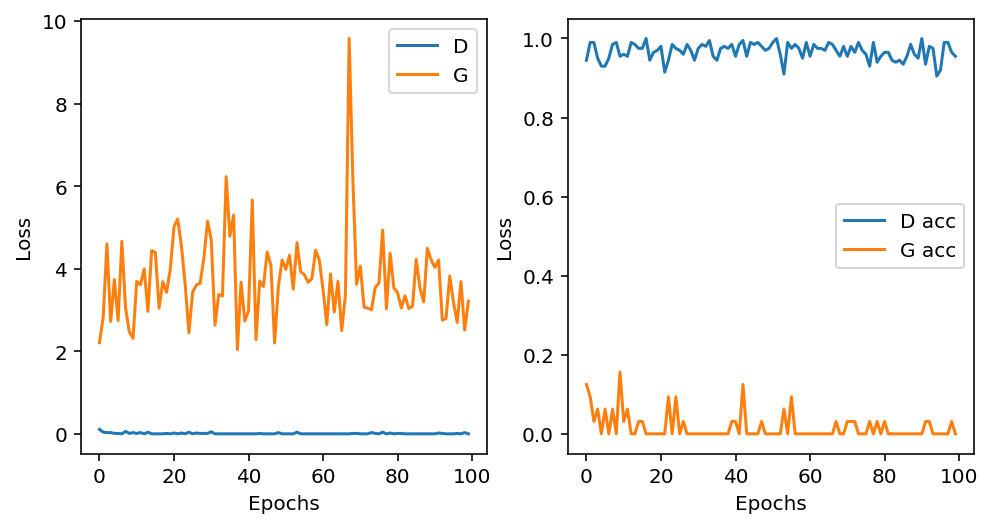

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

axes[0].plot(dloss, label='D')
axes[0].plot(gloss, label='G')
axes[0].legend()
axes[0].set(xlabel='Epochs', ylabel='Loss')
axes[1].plot(dacc, label='D acc')
axes[1].plot(gacc, label='G acc')
axes[1].set(xlabel='Epochs', ylabel='Loss')
axes[1].legend();

Finally, we can look at some of the sampled signals in the `../data/gan-sin` folder.

In [19]:
%ls ../data/gan-sin

sin_00000.png  sin_00020.png  sin_00040.png  sin_00060.png  sin_00080.png
sin_00001.png  sin_00021.png  sin_00041.png  sin_00061.png  sin_00081.png
sin_00002.png  sin_00022.png  sin_00042.png  sin_00062.png  sin_00082.png
sin_00003.png  sin_00023.png  sin_00043.png  sin_00063.png  sin_00083.png
sin_00004.png  sin_00024.png  sin_00044.png  sin_00064.png  sin_00084.png
sin_00005.png  sin_00025.png  sin_00045.png  sin_00065.png  sin_00085.png
sin_00006.png  sin_00026.png  sin_00046.png  sin_00066.png  sin_00086.png
sin_00007.png  sin_00027.png  sin_00047.png  sin_00067.png  sin_00087.png
sin_00008.png  sin_00028.png  sin_00048.png  sin_00068.png  sin_00088.png
sin_00009.png  sin_00029.png  sin_00049.png  sin_00069.png  sin_00089.png
sin_00010.png  sin_00030.png  sin_00050.png  sin_00070.png  sin_00090.png
sin_00011.png  sin_00031.png  sin_00051.png  sin_00071.png  sin_00091.png
sin_00012.png  sin_00032.png  sin_00052.png  sin_00072.png  sin_00092.png
sin_00013.png  sin_00033.png  sin_0005

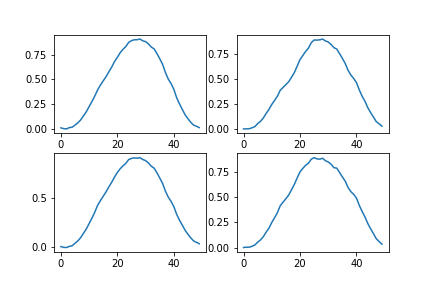

In [20]:
from keras.preprocessing import image

image.load_img('../data/gan-sin/sin_00099.png')

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Data Science with Python_](https://github.com/yoavram/DataSciPy) workshop.

The notebook was written using [Python](http://python.org/) 3.6.5.

This work is licensed under a [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)